In [40]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
from scipy.stats import f_oneway
sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
from IPython.display import display, HTML


In [88]:
X_test_with_proba = pd.read_csv('X_test_with_proba.csv')
X_test_with_proba

直播销量_编码_unimp_cluster_WOE  0_cluster_dbscan__OHE  \
0                     -1.053504                      0   
1                     -1.053504                      0   
2                     -1.053504                      0   
3                     -1.053504                      0   
4                      1.636742                      0   
...                         ...                    ...   
3539                  -0.380943                      0   
3540                  -0.380943                      0   
3541                  -1.053504                      1   
3542                   0.291619                      1   
3543                  -1.053504                      0   

      商品价格中位数_groupby_cluster  3_cluster_hdbscan__OHE  per30-60_销售均价分位数__OHE  \
0                   -0.058220                       1                      1   
1                    0.191335                       1                      1   
2                   -0.245452                       0                      0   
3                   -0.061379                       1                      1   
4                   -0.045843                       1                      0   
...                       ...                     ...                    ...   
3539                 0.053527                       0                      0   
3540                 0.948346                       0                      0   
3541                -0.065289                       0                      0   
3542                -0.068215                       0                      0   
3543                 0.077458                       1                      0   

      商品价格最大差值  cluster_dbscan_count_label    tsne_y  粉丝数_unimp_cluster_WOE  \
0    -0.035293                         1.0  1.304487              -0.538443   
1     0.376387                         1.0 -0.137710              -0.538443   
2    -0.035122                         0.0 -0.690086              -1.276042   
3    -0.035293                         1.0  1.635406              -0.538443   
4    -0.035293                         1.0  0.626237               0.936756   
...        ...                         ...       ...                    ...   
3539 -0.035293                         0.0 -0.690086               0.936756   
3540 -0.035293                         0.0 -0.690086              -0.538443   
3541 -0.032347                         2.0 -0.638805              -0.538443   
3542 -0.035293                         2.0 -0.638805               1.674355   
3543 -0.035293                         1.0 -0.327861              -0.538443   

      3_cluster_kmeans__OHE  ...  5_cluster_similarity__OHE  \
0                         0  ...                          0   
1                         0  ...                          0   
2                         0  ...                          1   
3                         0  ...                          0   
4                         0  ...                          0   
...                     ...  ...                        ...   
3539                      0  ...                          1   
3540                      0  ...                          1   
3541                      0  ...                          0   
3542                      0  ...                          0   
3543                      0  ...                          0   

      销售额_编码_unimp_cluster_WOE  1_cluster_kmeans__OHE  \
0                    -1.004448                      0   
1                    -1.004448                      0   
2                    -1.004448                      0   
3                    -1.004448                      0   
4                     0.619441                      0   
...                        ...                    ...   
3539                 -0.192504                      0   
3540                 -0.192504                      0   
3541                 -1.004448                      1   
3542                  0.619441                      1   
3543           

In [42]:
X_test_with_proba['acc'] = X_test_with_proba.apply(lambda row: '预测正确' if row['actual'] == row['pred'] else '预测错误', axis=1)

In [43]:
high_threshold = 0.7
low_threshold = 0.3
def significance(prob_1):
    if prob_1 > high_threshold:
        return '显著高转化率'
    if prob_1 < low_threshold:
        return '显著低转化率'
    else:
        return '不显著'
X_test_with_proba['significance'] = X_test_with_proba['prob_1'].apply(lambda x: significance(x))

# X_test_with_proba["显著性差别"] = X_test_with_proba["prob_1"].apply(lambda x: "显著高转化率" if x > 0.7 else ("显著低转化率" if x < 0.3 else "不显著"))

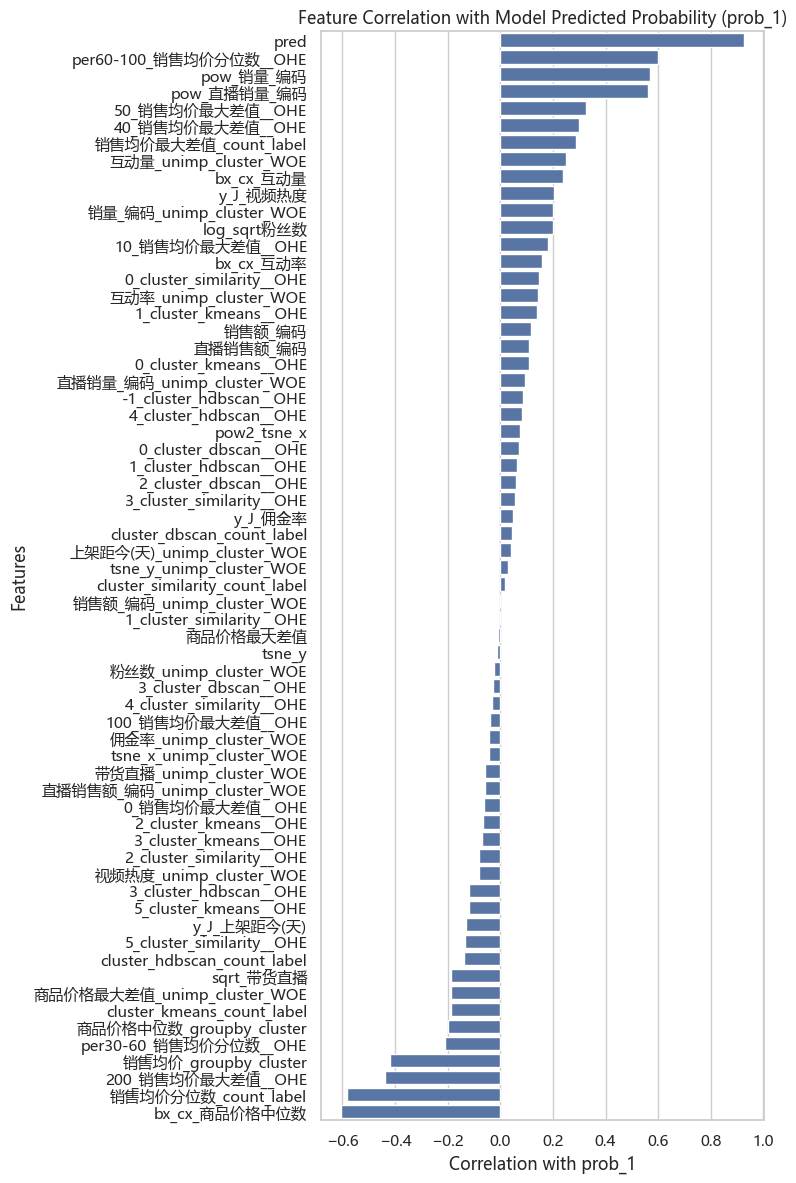

特征与预测概率 prob_1 的相关性（已删除 prob_0 和 prob_1）：
pred                      0.925312
per60-100_销售均价分位数__OHE    0.599149
pow_销量_编码                 0.568988
pow_直播销量_编码               0.562532
50_销售均价最大差值__OHE          0.327455
                            ...   
per30-60_销售均价分位数__OHE    -0.208463
销售均价_groupby_cluster     -0.417341
200_销售均价最大差值__OHE        -0.438726
销售均价分位数_count_label      -0.581815
bx_cx_商品价格中位数            -0.606568
Name: prob_1, Length: 64, dtype: float64


In [44]:
# 删除 prob_1 和 prob_0
X_test_with_prob_copy = X_test_with_proba.drop(['actual','significance','acc'],axis = 1)
# 计算特征与 prob_1 的相关性
correlation_matrix = X_test_with_prob_copy.corr()
correlation_with_prob = correlation_matrix["prob_1"].sort_values(ascending=False)
correlation_with_prob = correlation_with_prob.drop(["prob_1", "prob_0"], errors="ignore")

# 画出相关性水平条形图
plt.figure(figsize=(8, 12))  # 调整画布大小
sns.barplot(y=correlation_with_prob.index, x=correlation_with_prob.values, orient="h")  
plt.ylabel("Features")
plt.xlabel("Correlation with prob_1")
plt.title("Feature Correlation with Model Predicted Probability (prob_1)")
plt.tight_layout()
plt.show()

# 显示处理后的相关性数据
print("特征与预测概率 prob_1 的相关性（已删除 prob_0 和 prob_1）：")
print(correlation_with_prob)


In [57]:
# 获取所有特征列（排除 prob_1, prob_0, 显著性差别）
feature_columns = [col for col in X_test_with_proba.columns if col not in ["prob_1", "prob_0", "显著性差别",'actual','acc','pred']]
cont_cols=[f for f in X_test_with_proba.columns if X_test_with_proba[f].dtype  != 'O' and X_test_with_proba[f].nunique()>6 and f not in ["prob_1", "prob_0", "显著性差别",'actual']]

In [59]:
# 计算各类样本的特征均值
X_test_with_prob_copy = X_test_with_proba.drop(['actual','acc'],axis = 1)
feature_means = X_test_with_prob_copy.groupby("significance").mean()
html_table = feature_means.to_html()
display(HTML(html_table))

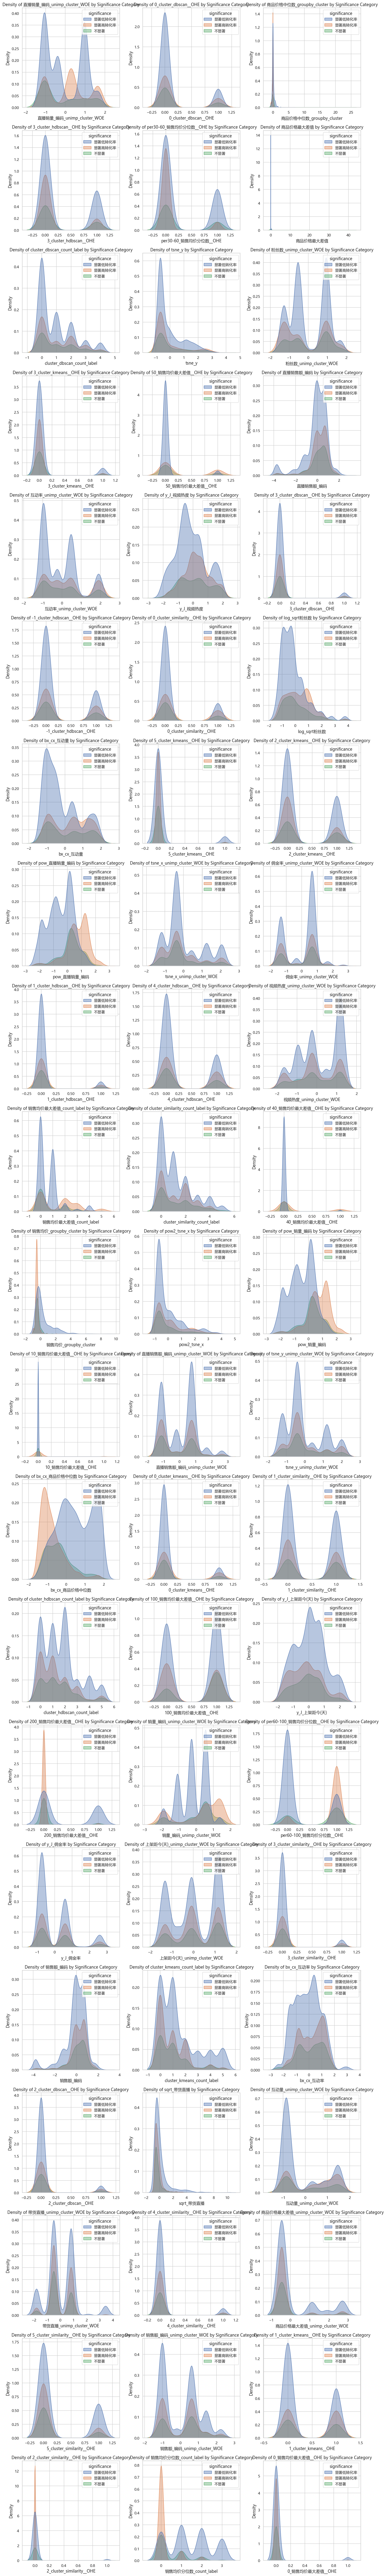

In [62]:
selected_features = [col for col in feature_columns if col != "significance"]# 选择前6个特征
num_rows = (len(feature_columns) + 2) // 3
fig = plt.figure(figsize=(15, num_rows*5))
i = 0

for feature in selected_features:
    i += 1
    plt.subplot(num_rows,3,i)
    sns.kdeplot(data=X_test_with_proba, x=feature, hue="significance", fill=True, alpha=0.4)
    plt.xlabel(feature)
    plt.title(f"Density of {feature} by Significance Category")
#     plt.legend(title="Significance Category")

plt.tight_layout()
plt.show()


In [10]:
# 单因素方差分析 显著性 P 值
p_values = {}
for feature in feature_columns:
    groups = [X_test_with_proba[X_test_with_proba["significance"] == cat][feature] for cat in X_test_with_proba["significance"].unique()]
    p_values[feature] = f_oneway(*groups)[1]  
    
p_values_df = pd.DataFrame(p_values.items(), columns=["Feature", "P-value"]).sort_values(by="P-value").reset_index(drop=True)

html_table = p_values_df.to_html()
display(HTML(html_table))


In [76]:
def pred_vs_actual(significance,actual,acc):
    if (significance == '显著高转化率' and actual == 1) :
        return '显著正确-高转化'
    if (significance == '显著低转化率' and actual == 0) :
        return '显著正确-低转化'
    if (significance == '显著高转化率' and actual == 0) :
        return '显著错误-低转化误认为高转化'
    if (significance == '显著低转化率' and actual == 1) :
        return '显著错误-高转化误认为低转化'
    if (significance == '不显著' and acc =='预测正确') :
        return '非显著但正确'
    if (significance == '不显著' and acc =='预测错误'):
        return '非显著且错误'
    
X_test_with_proba['显著性-正确性'] = X_test_with_proba.apply(lambda row: pred_vs_actual(row['significance'], row['actual'], row['acc']), axis=1)

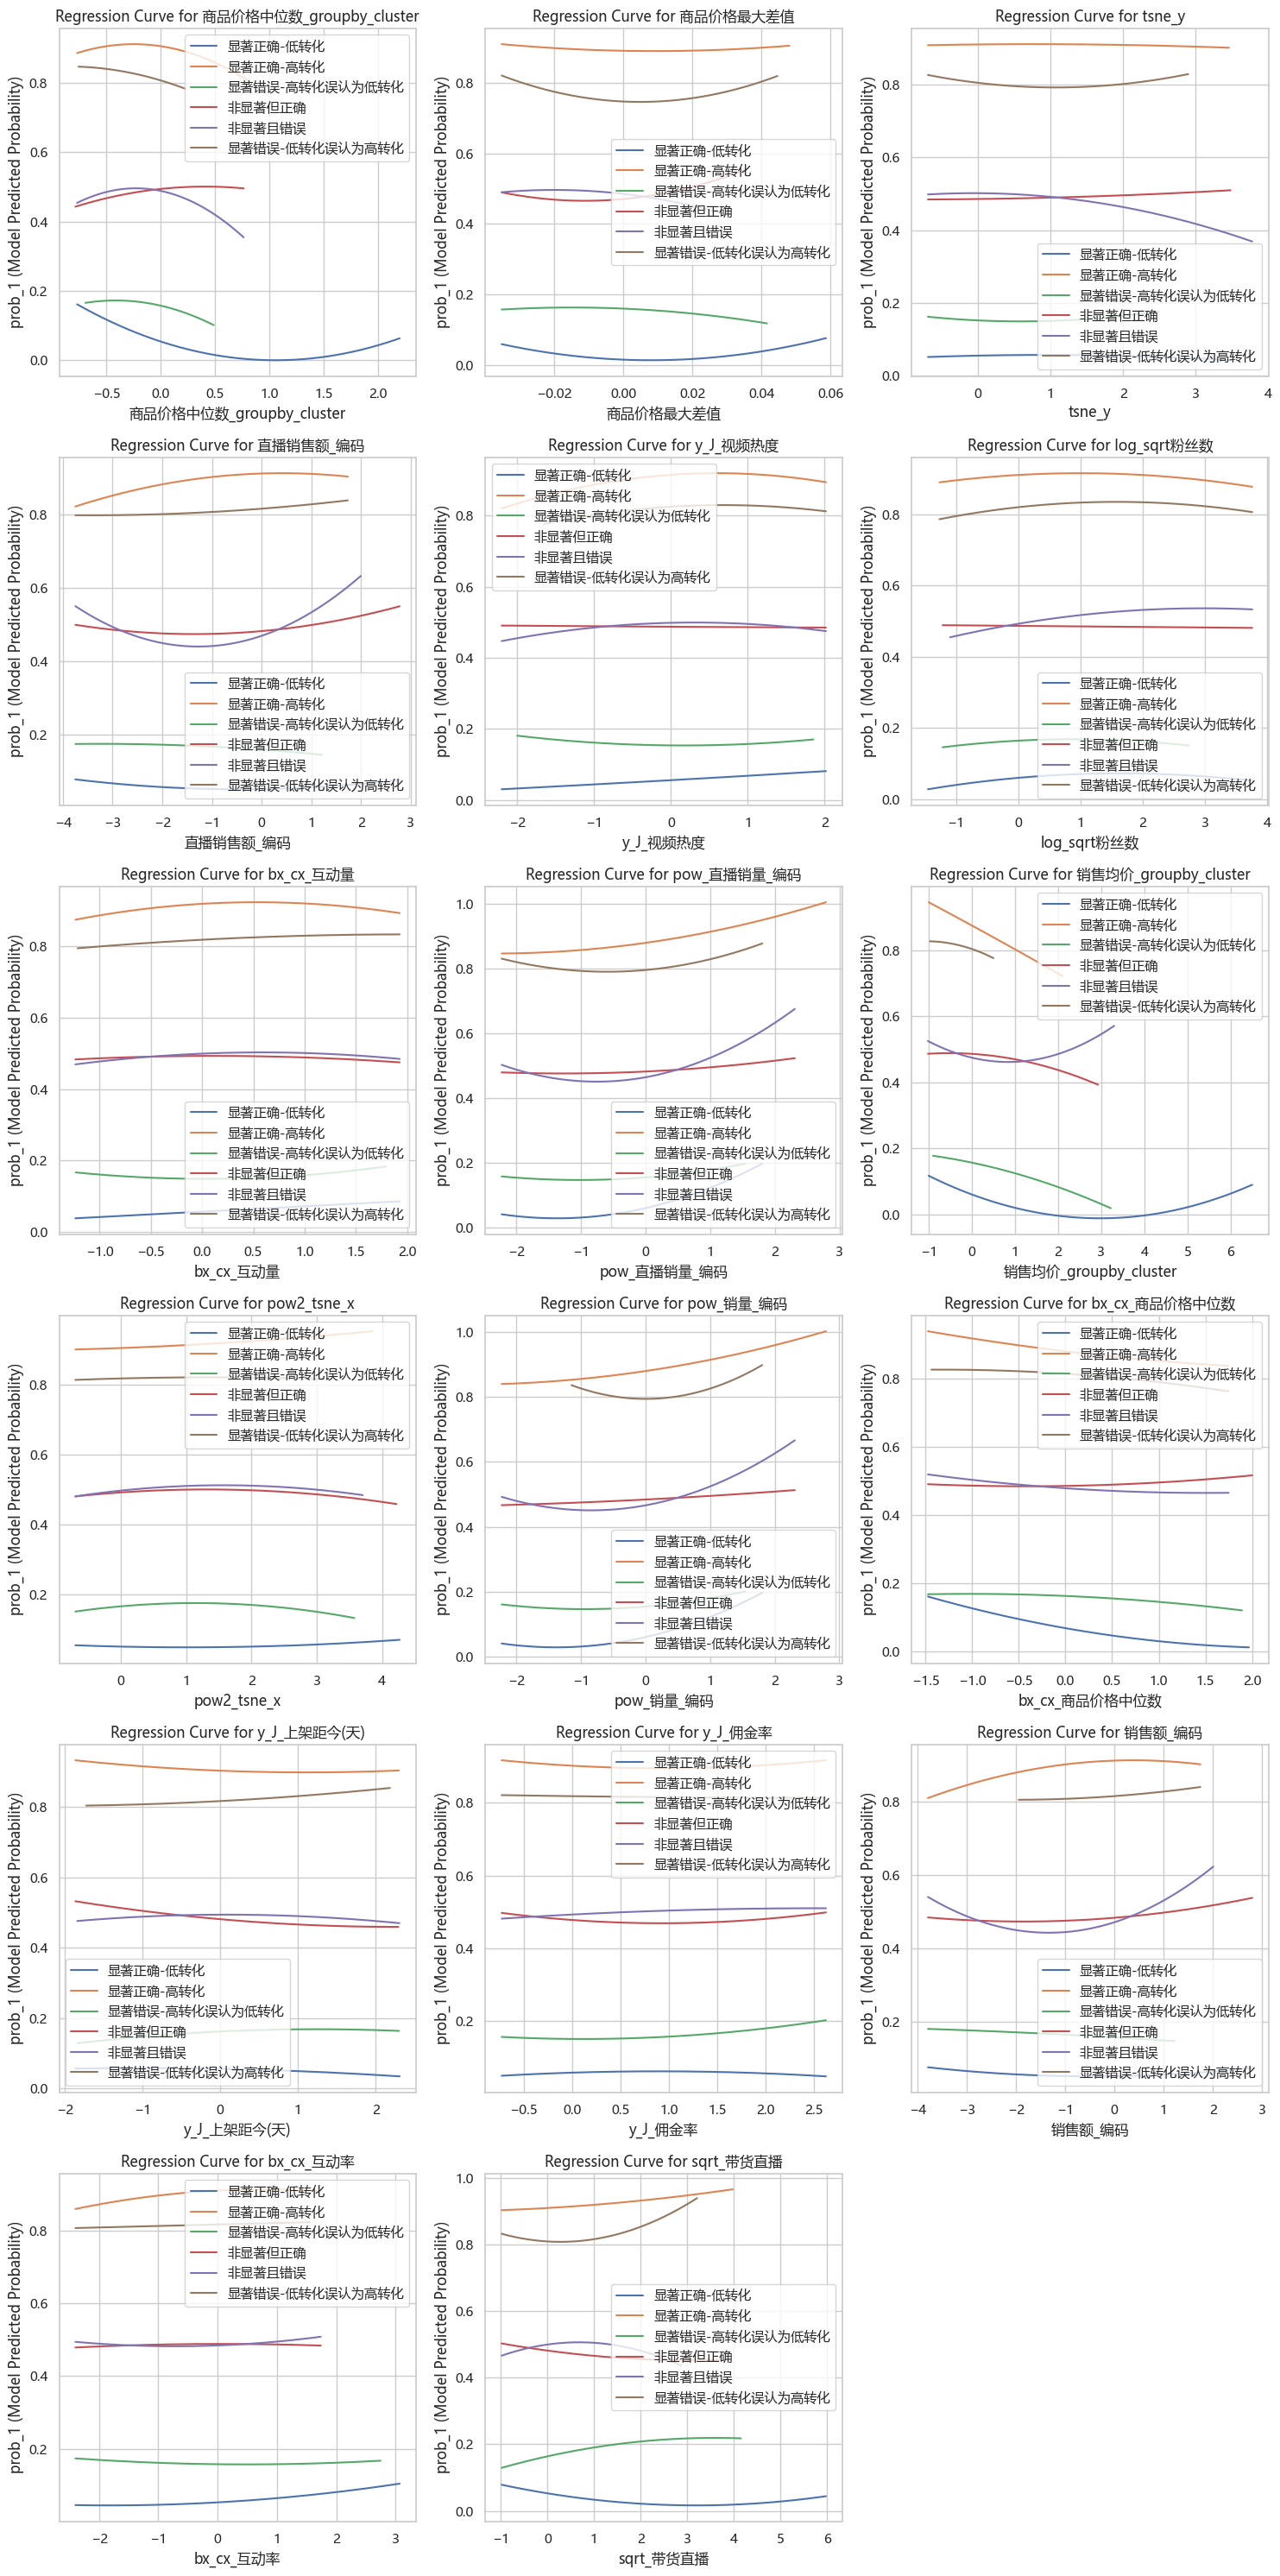

In [86]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 计算行数
num_rows = (len(cont_cols) + 2) // 3
fig = plt.figure(figsize=(15, num_rows*5))

# 遍历所有数值型特征
for i, feature in enumerate(cont_cols):
    # 计算 IQR，去除离群点
    Q1 = X_test_with_proba[feature].quantile(0.05)
    Q3 = X_test_with_proba[feature].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = X_test_with_proba[(X_test_with_proba[feature] >= lower_bound) & (X_test_with_proba[feature] <= upper_bound)].copy()
    
    plt.subplot(num_rows,3,i+1)
    # 遍历每个 `显著性-正确性` 类别，分别拟合曲线
    for category in filtered_data["显著性-正确性"].unique():
        subset = filtered_data[filtered_data["显著性-正确性"] == category]

        # 用 numpy.polyfit() 拟合二次多项式回归
        coeffs = np.polyfit(subset[feature], subset["prob_1"], deg=2)
        poly_func = np.poly1d(coeffs)

        # 生成平滑曲线
        x_range = np.linspace(subset[feature].min(), subset[feature].max(), 1000)
        y_range = poly_func(x_range)

        # 绘制拟合曲线（不显示散点）
        plt.plot(x_range, y_range, label=f"{category}")
    plt.xlabel(feature)
    plt.ylabel("prob_1 (Model Predicted Probability)")
    plt.title(f"Regression Curve for {feature}")
    plt.legend()

plt.tight_layout()
plt.show()


In [87]:
# num_rows = (len(cont_cols) + 2) // 3
# fig = plt.figure(figsize=(15, num_rows*5))
# i = 0
# # 逐个绘制散点图
# for feature in cont_cols:
#     i += 1
#     Q1 = X_test_with_proba[feature].quantile(0.05)
#     Q3 = X_test_with_proba[feature].quantile(0.95)
#     IQR = Q3 - Q1
#     # 计算离群点范围
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     filtered_data = X_test_with_proba[(X_test_with_proba[feature] >= lower_bound) & (X_test_with_proba[feature] <= upper_bound)]

#     plt.subplot(num_rows,3,i)
#     sns.scatterplot(data=filtered_data, y=feature, x=filtered_data.index, hue="significance", alpha=0.6)
#     plt.ylabel(feature)
#     plt.xlabel("Sample Index ")
#     plt.title(f"Scatter Plot of {feature}")
#     plt.legend(title="Significance Category")

# plt.tight_layout()
# plt.show()
